# RAMP use case 1: seismic monitoring design for detection of CO2 plumes in shallow aquifer, Kimberlina 1.2 models

## Objective
Design optimal seismic monitoring plans by minimizing a trade-off between monitoring intensity and time to plume detection.

## Table of Contents: <a class="anchor" id="bullet0"></a>
* [1. User defines site settings, objectives and criteria.](#bullet1)
* [2. Setup of the spatial and temporal data.](#bullet2)
* [3. Input: Geophysical models (velocity models) are loaded.](#bullet3)
  * [a. Shallow plume](#bullet3a)
  * [b. Middle-depth plume](#bullet3b)
  * [c. Deep plume](#bullet3c)
* [4. Input: Seismic data is loaded.](#bullet4)
  * [a. Seismic data example](#bullet4a)
  * [b. Seismic data difference example](#bullet4b)
* [5. Visualize possible predefined acquisition configurations.](#bullet5)
  * [a. Complete seismic survey](#bullet5a)
  * [b. Dense array](#bullet5b)
  * [c. Sparse array](#bullet5c)
  * [d. Distribution of number of receivers](#bullet5d)
* [6. Examples of calculated parameter: NRMS.](#bullet6)
  * [a. Selected scenario](#bullet6a)
* [7. Detectability as a function of an NRMS threshold.](#bullet7)
  * [a. Percentage of leakage scenarios detected](#bullet7a)
  * [b. Interactive plot 1](#bullet7b)
  * [c. Interactive plot 2](#bullet7c)
* [8. Optimization.](#bullet8)
  * [a. One step results](#bullet8a)
  * [b. 3 steps results, 3 subsets of arrays](#bullet8b)
  * [c. JupyterDash app](#bullet8c)

### 1. User defines site settings, objectives and criteria. <a class="anchor" id="bullet1"></a>

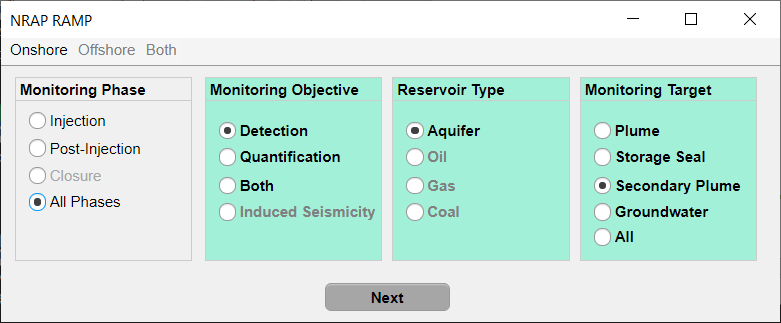

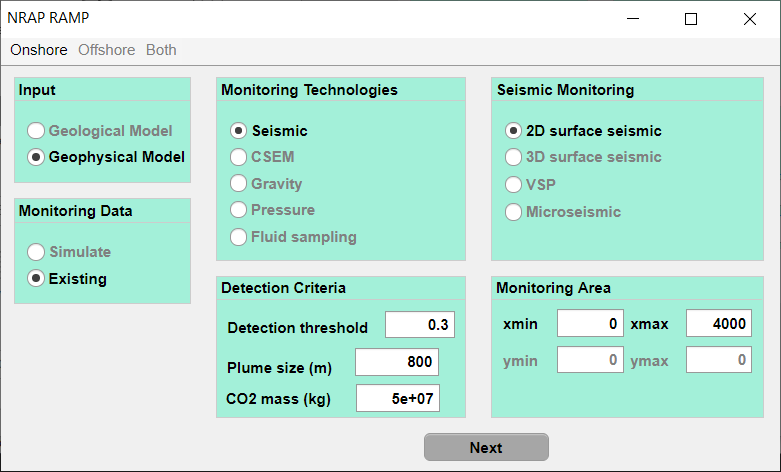

### 2. Setup of the spatial and temporal data for the workflow <a class="anchor" id="bullet2"></a>
Back to [TOC](#bullet0).

In [1]:
# Import required Python packages
import os
import sys
import numpy as np
import scipy.interpolate as scinterp
import matplotlib.pyplot as plt

In [2]:
 %matplotlib inline

In [3]:
# Temporal data
time_points = 10*np.arange(1, 21)
num_time_points = len(time_points)
final_year = 200
num_intervals = (final_year-10)//10
time_array = 365.25*np.linspace(10.0, final_year, num=num_intervals+1)
ft = scinterp.interp1d(range(len(time_array)), time_array/365.25, kind='linear')

# Scenario data
excluded = [37, 118, 136, 150, 182, 245] # 6 scenarios
scenarios = list(set(range(1, 307)).difference(excluded))
num_scenarios = len(scenarios)

# Domain coordinates
coordinates = {1: 4000 + 10*np.arange(401),
               2: 10*np.arange(141)}  # 1 is x, 2 is z

### 3. Input: Geophysical models (velocity models) are loaded. <a class="anchor" id="bullet3"></a>
Back to [TOC](#bullet0).

In [4]:
# Setup directories
data_directory = 'data'
output_directory = 'output'

In [5]:
# Load velocity data
velocity_data_file = os.path.join(data_directory, 'velocity_data_50_scenarios.npz')
velocity = np.load(velocity_data_file)['data']
print('Velocity data shape:', velocity.shape)

Velocity data shape: (50, 20, 401, 141)


In [6]:
# Define plotting function for velocity data
def plot_velocity(velocity, scen):
    xs = coordinates[1]
    zs = coordinates[2]

    xxs, zzs = np.meshgrid(xs, zs, indexing='ij')
    labelsize = 12
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 10),
                            sharex=True, sharey=True)
    vmin = np.min(velocity)
    vmax = np.max(velocity)
    for ind in range(num_time_points):
        row = ind//5
        col = ind%5
        pic = axs[row, col].scatter(xxs, zzs, c=velocity[ind],
                              cmap='turbo', marker='s',
                              vmin=vmin, vmax=vmax)
        axs[row, col].set_title('t = {} years'.format((ind+1)*10),
                                fontsize=labelsize+2)
        axs[row, col].tick_params(axis='both', which='major',
                                  labelsize=labelsize)
    axs[0, 0].invert_yaxis()
    for row in range(4):
        axs[row, 0].set_ylabel('depth, [m]', fontsize=labelsize+1)
    for col in range(5):
        axs[3, col].set_xlabel('x, [m]', fontsize=labelsize+1)
    fig.suptitle('Velocity data (Scenario {})'.format(scen),
                 fontsize=labelsize+4)
    fig.subplots_adjust(left=0.05, right=0.9)
    cax = plt.axes([0.92, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(pic, ax=axs, cax=cax)
    cbar.ax.tick_params(labelsize=labelsize-1)
    cbar.set_label(label='[m/s]', size=labelsize)

#### Shallow plume example: <a class="anchor" id="bullet3a"></a>

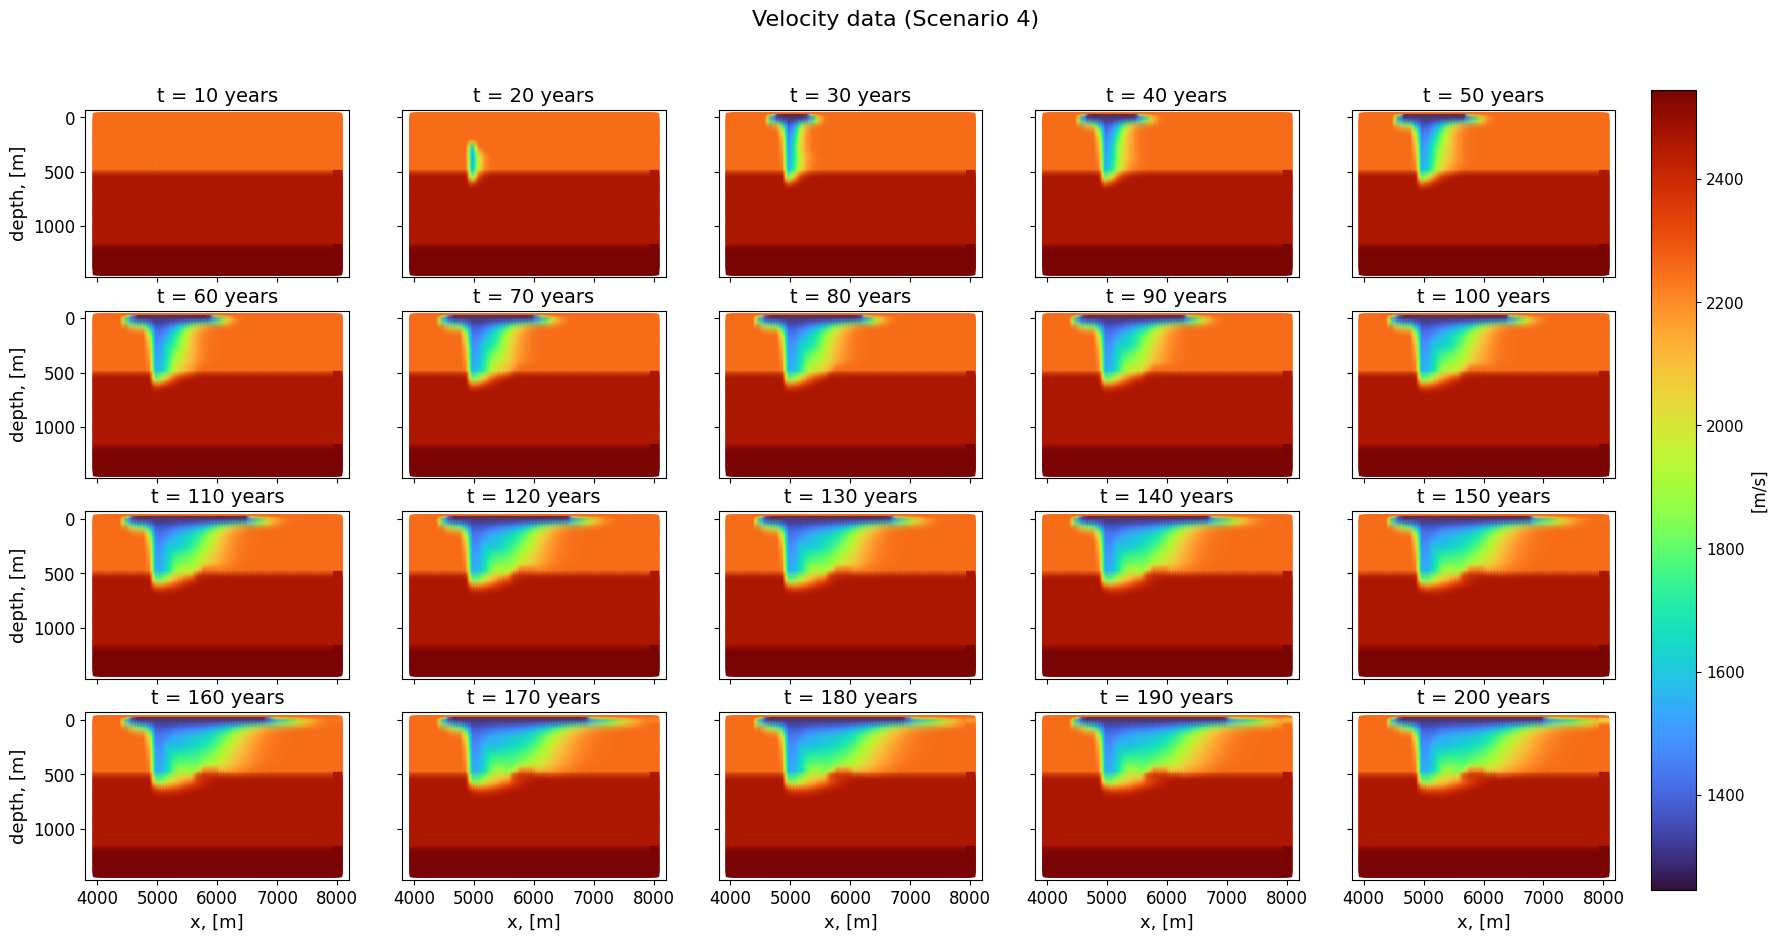

In [7]:
scen = 4 
plot_velocity(velocity[scen], scen)

#### Mid-depth plume example: <a class="anchor" id="bullet3b"></a>

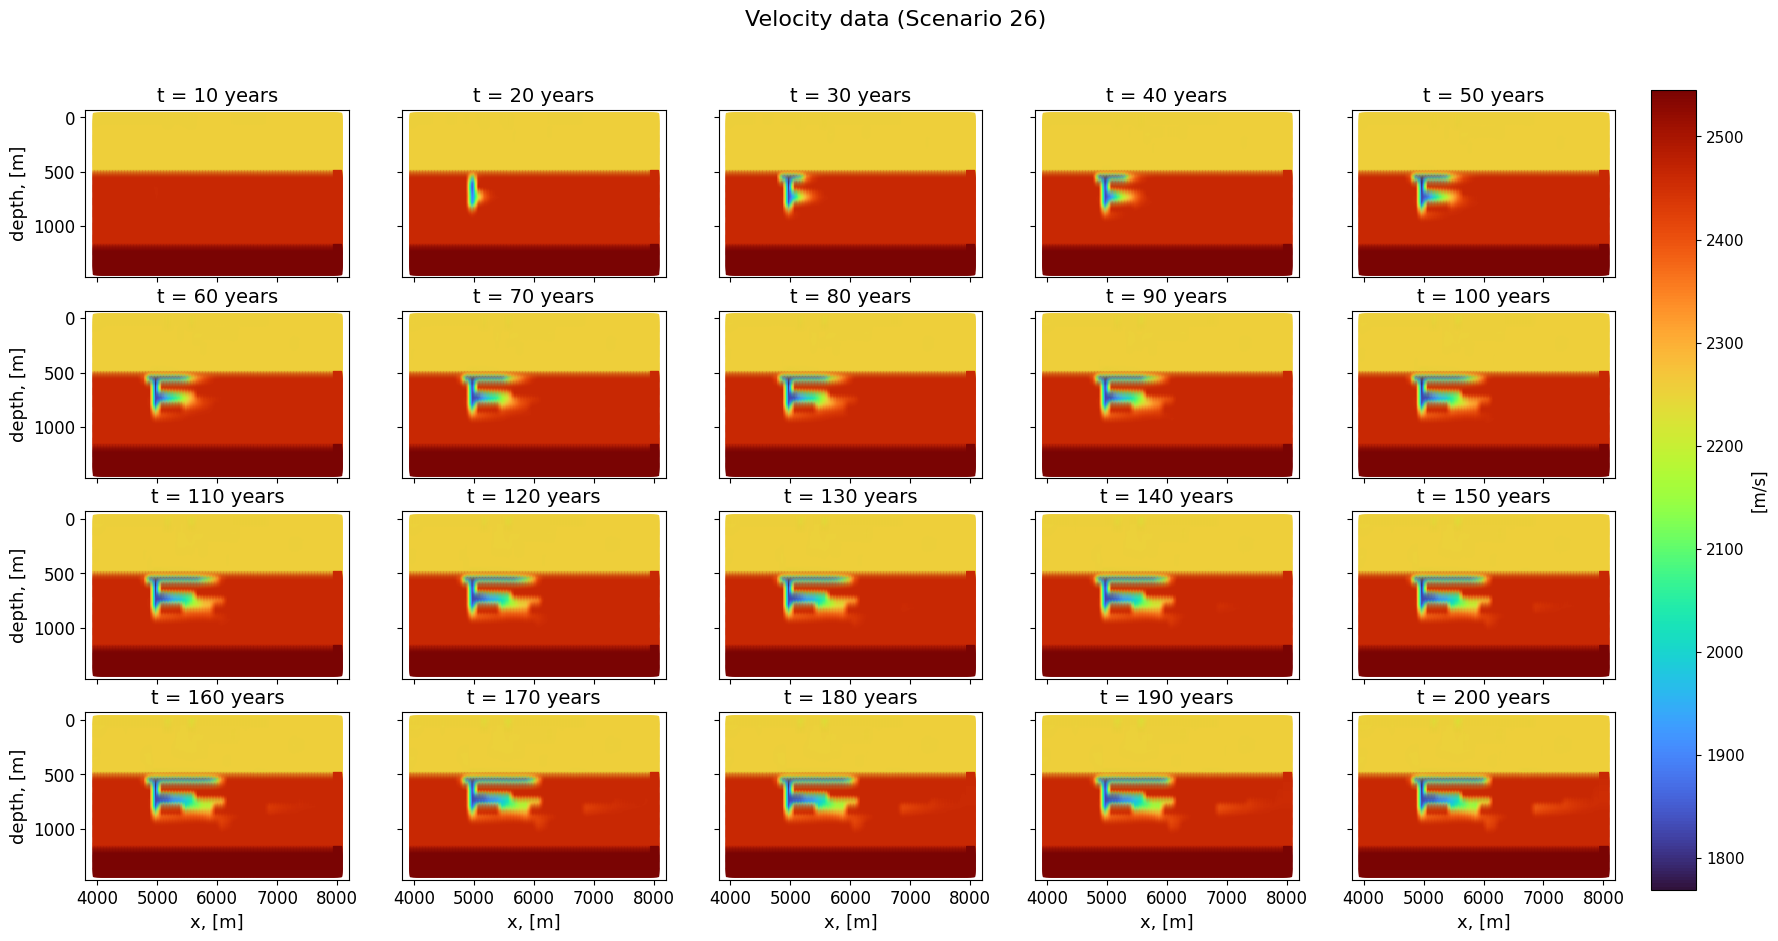

In [8]:
scen = 26
plot_velocity(velocity[scen], scen)

#### Deep plume example: <a class="anchor" id="bullet3c"></a>

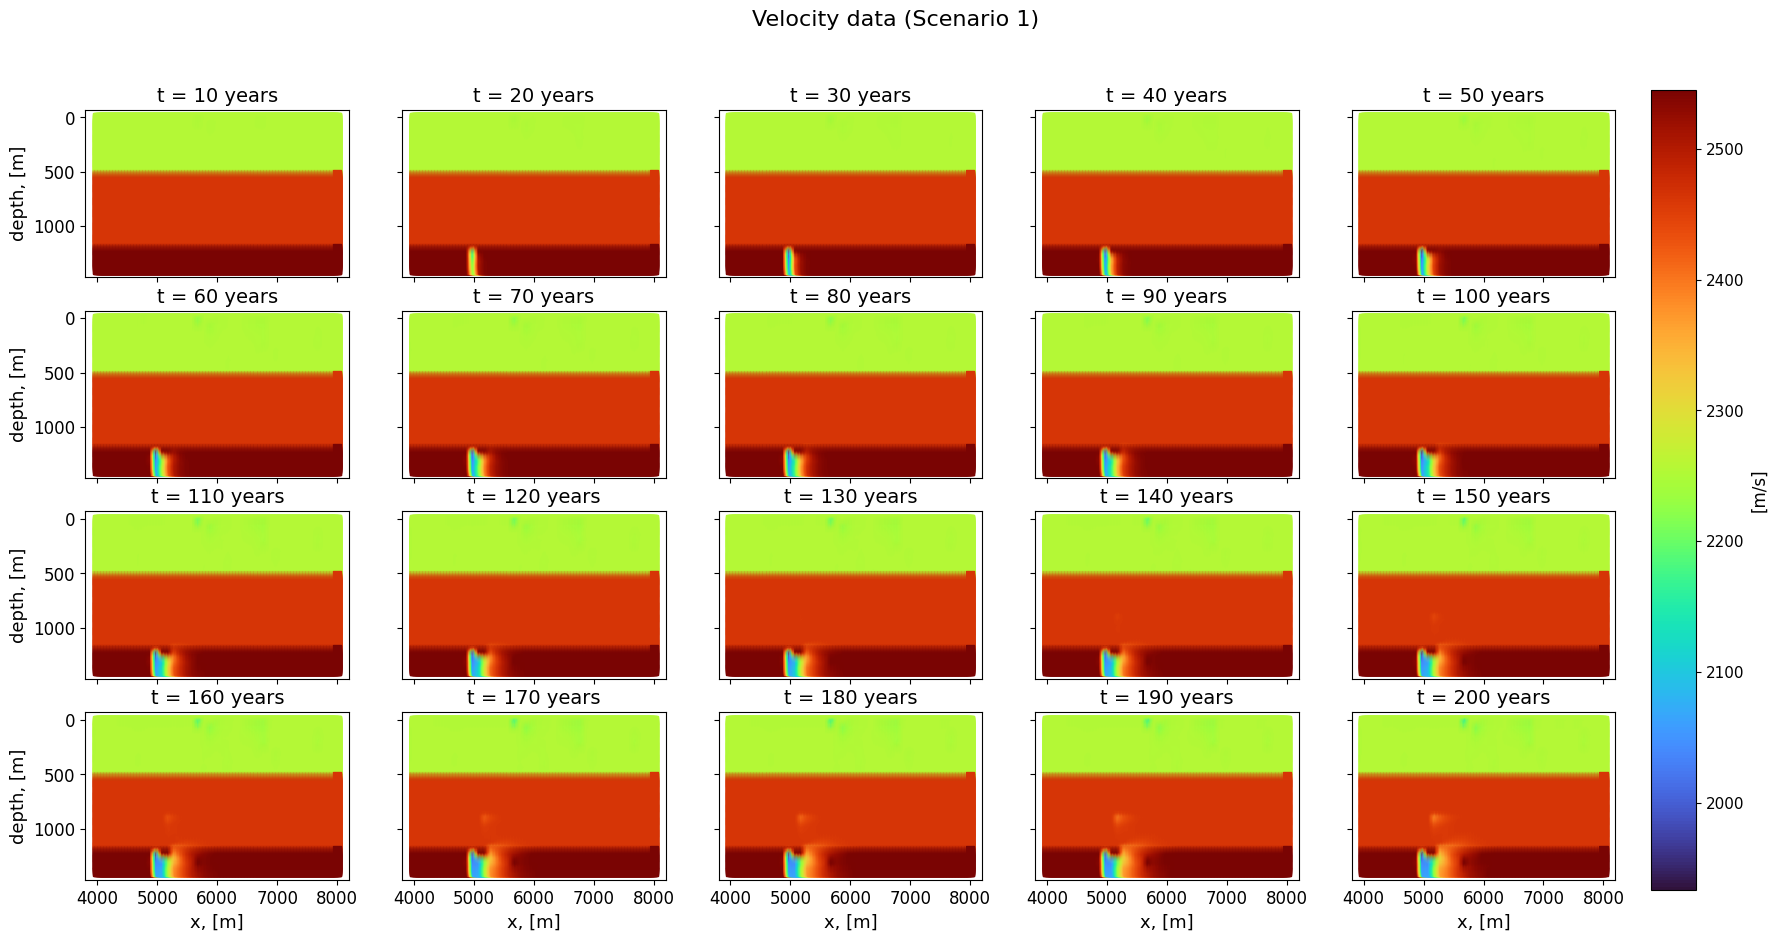

In [9]:
scen = 1
plot_velocity(velocity[scen], scen)

### 4. Input: Seismic data is loaded. <a class="anchor" id="bullet4"></a>
Back to [TOC](#bullet0).

In [10]:
# Load seismic data
seismic_data_file = os.path.join(data_directory, 'seismic_optimization_data_5_scenarios.npz')
seismic = np.load(seismic_data_file)['data']
print('Seismic data shape:', seismic.shape)

Seismic data shape: (5, 20, 9, 101, 1251)


In [11]:
# Load seismic data difference
delta_seismic_data_file = os.path.join(data_directory, 'delta_seismic_optimization_data_5_scenarios.npz')
delta_seismic = np.load(delta_seismic_data_file)['data']
print('Difference in seismic data shape:', delta_seismic.shape)

Difference in seismic data shape: (5, 20, 9, 101, 1251)


In [12]:
# Define plotting function for seismic data
def plot_seismic(data, scen, source_ind, delta_seismic=False):
    x = np.linspace(0, 100, num=5)
    xlabels = 4+np.linspace(0, 4, num=5)
    y = np.linspace(0, 1200, num=5)
    ylabels = np.linspace(0, 2.5, num=5)
    time_indices = range(1, 20, 2)
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18, 5),
                            sharex=True, sharey=True)
    # Cycle over time indices
    for ind, time_ind in enumerate(time_indices):
        row = ind//5
        col = ind%5
        ax_im = axs[row, col].imshow(data[scen][time_ind][source_ind-1, :, :].T,
                                     cmap='gray', aspect='auto')
        axs[row, col].set_title('t = {} years'.format((time_ind + 1)*10))

        # Add colorbar
        color_bar = fig.colorbar(ax_im, ax=axs[row, col], orientation='vertical')
        color_bar.ax.tick_params(axis='y', which='major', labelsize=8)

    for row in range(2):
        axs[row, 0].set_yticks(y, labels=ylabels)
        axs[row, 0].set_ylabel('Time, [sec]')
    for col in range(5):
        axs[1, col].set_xticks(x, labels=xlabels)
        axs[1, col].set_xlabel('Receiver location, [km]')

    if delta_seismic:
        fig.suptitle('Scenario {}: Seismic data difference (Source {})'.format(scen, source_ind))
    else:
        fig.suptitle('Scenario {}: Seismic data (Source {})'.format(scen, source_ind))

#### Seismic data for a selected scenario and source <a class="anchor" id="bullet4a"></a>

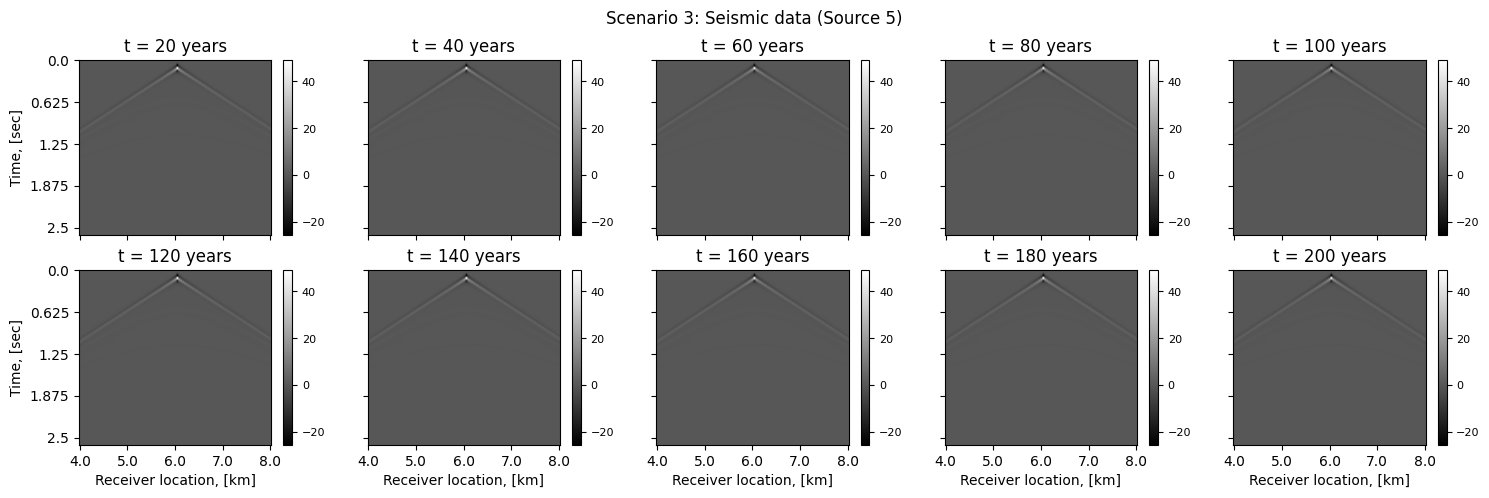

In [13]:
# Plot seismic data for a selected scenario
scen = 3
source_ind = 5
plot_seismic(seismic, scen, source_ind, delta_seismic=False)

#### Seismic data difference for a selected scenario and source <a class="anchor" id="bullet4b"></a>

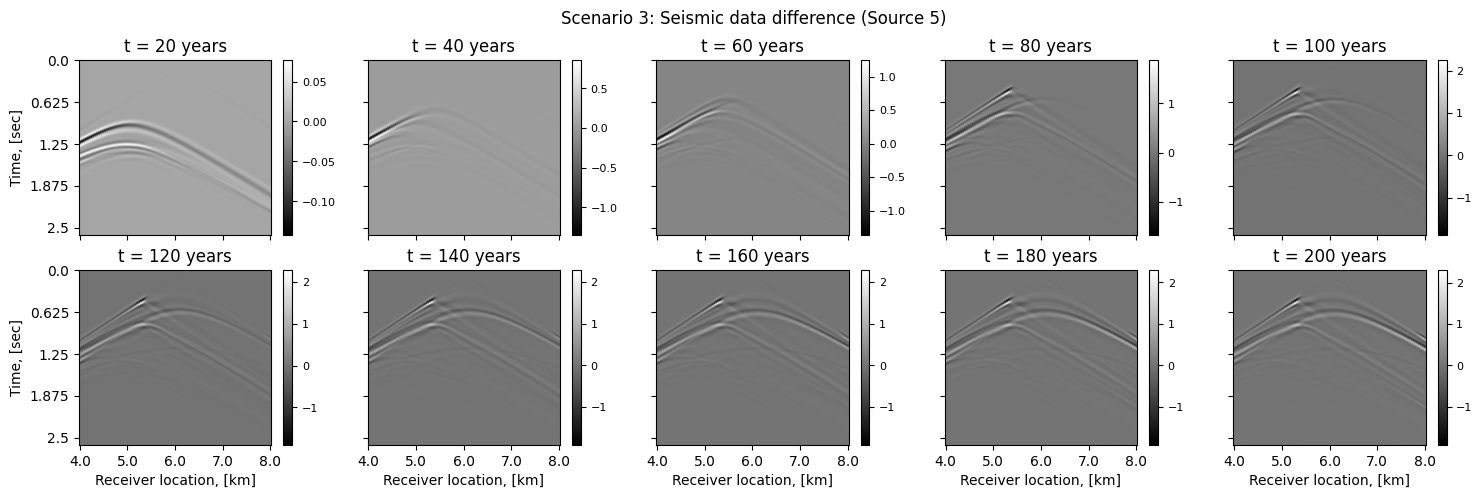

In [14]:
# Plot difference in seismic data for a selected scenario
scen = 3
source_ind = 5
plot_seismic(delta_seismic, scen, source_ind, delta_seismic=True)

### 5. Visualize possible predefined acquisition configurations. <a class="anchor" id="bullet5"></a>
Back to [TOC](#bullet0).

In [15]:
# Load required classes and methods
sys.path.insert(0, os.sep.join(['..', '..', '..', 'source']))
from ramp.seismic_configuration import SeismicSurveyConfiguration
from ramp.seismic_configuration import five_n_receivers_array_creator

In [16]:
# Define coordinates of sources
num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]

# Define coordinates of receivers
num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]

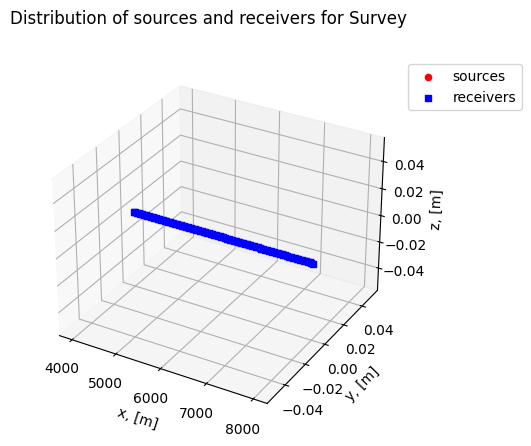

In [17]:
# Create survey configuration with defined coordinates
array_creator_kwargs = {'source_coords': sources,
                        'receiver_coords': receivers}
configuration = SeismicSurveyConfiguration(
    sources, receivers, name='Survey', create_arrays=True,
    array_creator=five_n_receivers_array_creator,
    array_creator_kwargs=array_creator_kwargs)
configuration.plot_configuration()

In [18]:
# Define plotting function for arrays
def plot_array(sources, receivers, configuration, ind=1, plot_all=False):

    fig = plt.figure(figsize=(13, 2))
    ax = fig.add_subplot(111)
    
    if not plot_all:
        sind = configuration.arrays[ind-1]['source']
        rind = configuration.arrays[ind-1]['receivers']
        nr = configuration.arrays[ind-1]['num_receivers'] # number of receivers in the array
        ax.plot([sources[sind, 0]], [0], 'or', label='source', markersize=6)
        ax.plot(receivers[rind, 0], nr*[0], 'sb', label='receivers', markersize=3)

        ax.annotate('{}'.format(sind+1), (sources[sind, 0], 0),
                    xytext=(-3, 5),  # 4 points vertical offset
                    textcoords='offset points', color='red')
        for rec_ind in range(nr):
            ax.annotate('{}'.format(rind[rec_ind]+1), (receivers[rind[rec_ind], 0], 0),
                    xytext=(-3, 5),  # 4 points vertical offset
                    textcoords='offset points', color='blue')
        ax.set_title('Location of source and receivers for array {}'.format(ind))
        
    else:
        ns = len(sources)
        nr = len(receivers)
        ax.plot(sources, ns*[0], 'or', label='sources', markersize=6)
        ax.plot(receivers, nr*[0], 'sb', label='receivers', markersize=3)
        ax.set_title('Location of sources and receivers for the whole survey')
        
    ax.set_xlim(4000, 8000)
    ax.set_xlabel('x, [m]')
    ax.set_yticks([0], labels=[0])
    ax.set_ylabel('depth, [m]')
    ax.legend()    

#### Complete seismic survey <a class="anchor" id="bullet5a"></a>

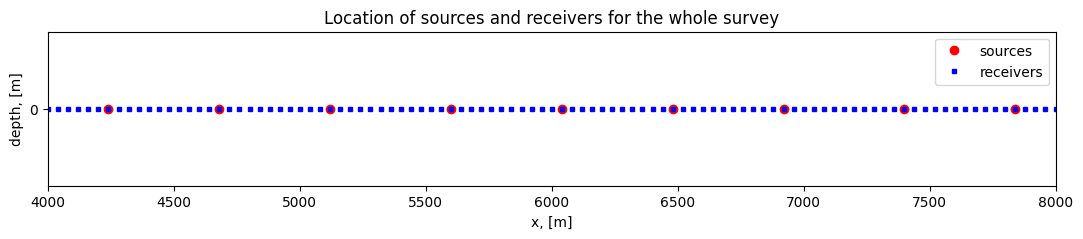

In [19]:
plot_array(sources[:, 0], receivers[:, 0], configuration, plot_all=True)

#### Dense array <a class="anchor" id="bullet5b"></a>

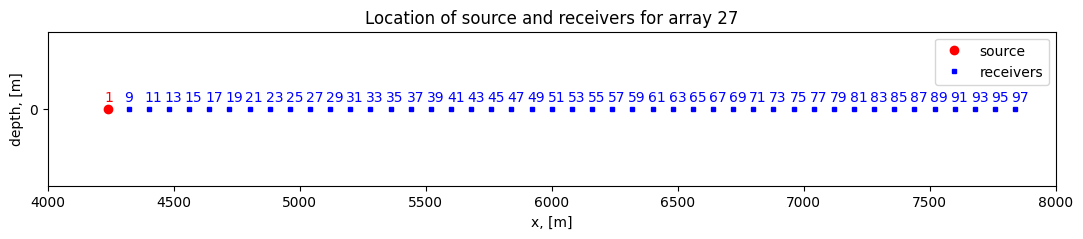

In [20]:
plot_array(sources, receivers, configuration, 27)

#### Sparse array <a class="anchor" id="bullet5c"></a>

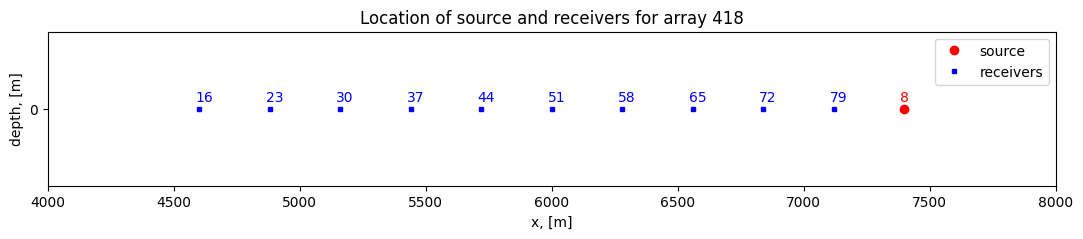

In [21]:
plot_array(sources, receivers, configuration, 418)

#### Distribution of number of receivers <a class="anchor" id="bullet5d"></a>

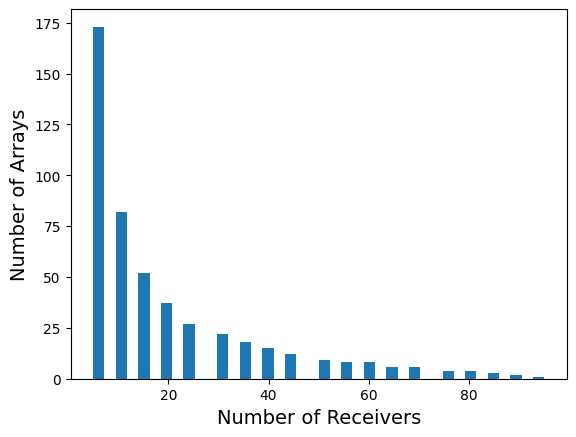

In [22]:
# Visualize distribution of number of receivers in the set of produced arrays
numR = np.array([configuration.arrays[key]['num_receivers'] for key in configuration.arrays.keys()])
produced_arrays = configuration.arrays

iSparse = np.where(numR<=21)[0]
iMedium = np.where(numR<=51)[0]
iDense  = list(range(len(numR)))

plt.figure()
plt.hist(numR, 40)
plt.xlabel('Number of Receivers', fontsize=14)
plt.ylabel('Number of Arrays', fontsize=14);

### 6. Examples of calculated parameter: NRMS. <a class="anchor" id="bullet6"></a>
NRMS is a normalized root-mean-square difference along the 2D seismic line. It is calculated as

\begin{align}
NRMS = \frac{200*\sqrt{\sum_{d_1}^{d^2}(trace_t - trace_{t_0})^2/N}}{\sqrt{\sum_{d_1}^{d^2}trace_t^2/N}+\sqrt{\sum_{d_1}^{d^2}trace_{t_0}^2/N}},
\end{align}

where $trace_t$ and $trace_{t_0}$ are the traces at time step $t$ and at the initial time step $t_0$; $d_1$ and $d_2$ are the start and end depths of the desired depth window; $N$ is the number of samples per trace within the desired window.

Back to [TOC](#bullet0).

In [23]:
# Load nrms data
nrms_data_file = os.path.join(data_directory, 'nrms_optimization_data_300_scenarios.npz')
nrms = np.load(nrms_data_file)['data']
print('NRMS data shape', nrms.shape)

NRMS data shape (300, 20, 9, 101)


In [24]:
# Define plotting function for NRMS
def plot_nrms(nrms, scen):
    x = np.linspace(0, 100, num=11)
    xlabels = np.linspace(1, 101, num=11, dtype=int)
    y = np.linspace(0, 8, num=9)
    ylabels = np.linspace(1, 9, num=9, dtype=int)
    time_indices = range(1, 20, 2)
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 5),
                                sharex=True, sharey=True)
    # Cycle over time indices
    for ind, time_ind in enumerate(time_indices):
        row = ind//5
        col = ind%5
        ax_im = axs[row, col].imshow(nrms[scen][time_ind], vmin=0, vmax=120,
                                     cmap='viridis', aspect='auto')
        axs[row, col].set_title('t = {} years'.format((time_ind + 1)*10))

        # Add colorbar
        color_bar = fig.colorbar(ax_im, ax=axs[row, col], orientation='vertical')
        color_bar.ax.tick_params(axis='y', which='major', labelsize=8)

    # Set x-labels
    for col in range(5):
        axs[1, col].set_xticks(x, labels=xlabels)
        axs[1, col].set_xlabel('Receivers')

    # Set y-labels
    for row in range(2):
        axs[row, 0].set_yticks(y, labels=ylabels)
        axs[row, 0].set_ylabel('Sources')

    fig.suptitle('Scenario {}: NRMS'.format(scen))

#### NRMS data for a selected scenario  <a class="anchor" id="bullet6a"></a>

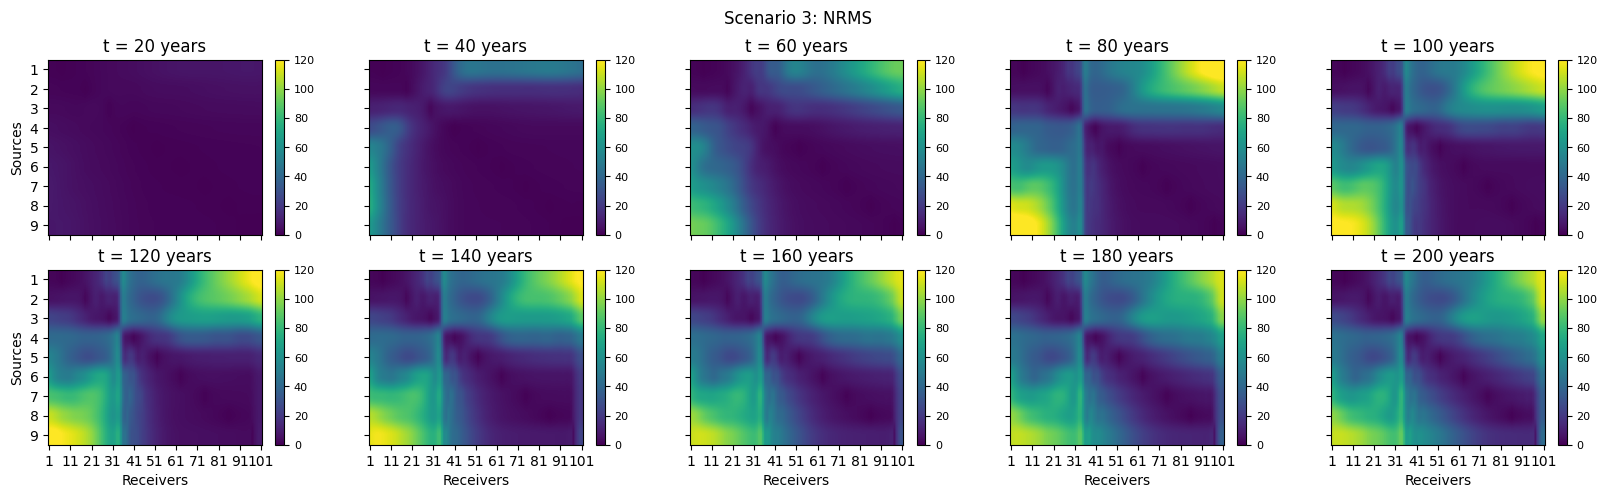

In [25]:
# Plot NRMS values
scen = 3
plot_nrms(nrms, scen)

### 7. Detectability as function of a threshold. <a class="anchor" id="bullet7"></a>
Back to [TOC](#bullet0).

In [26]:
# Obtain maximum NRMS values for all scenarios
max_nrms_values = {}
max_data_all = {}
for ind, tp in enumerate(time_points[1:]):
    max_data_all[tp] = nrms[:, ind+1, :, :]
    if ind != 0:
        max_nrms_values[tp] = np.max(max_data_all[tp], axis=(1, 2))  # maximum along sources and receivers axes
    else:
        max_nrms_values[tp] = np.max(nrms[:, ind+1, :, :], axis=(1, 2))

In [27]:
# Define NRMS threshold values
nrms_thresholds = [5, 10, 15]
print(nrms_thresholds)

[5, 10, 15]


In [28]:
# Determine how many of the leak scenarios will be detected with the full set of sources and receivers
detected_counts = {}
detected_prob = {}
undetected_leaks_scenarios = {}
for threshold in nrms_thresholds:
    detected_counts[threshold] = np.zeros(num_time_points)
    detected_prob[threshold] = np.zeros(num_time_points)
    for ind, tp in enumerate(time_points[1:]):  # starting with time point of 20 years
        detected_counts[threshold][ind+1] = len(np.where(max_nrms_values[tp] >= threshold)[0])
        #print(detected_counts[threshold][ind+1])
        detected_prob[threshold][ind+1] = 100*detected_counts[threshold][ind+1]/300

#### Percentage of leakage scenarios detected for the whole seismic survey as function of threshold <a class="anchor" id="bullet7a"></a>

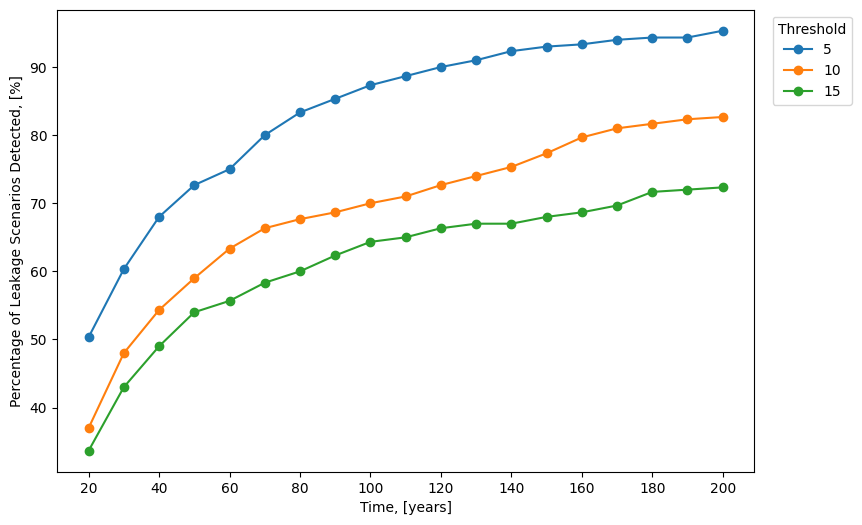

In [29]:
# Plot probability of detection based on threshold
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
for threshold in nrms_thresholds:
    axs.plot(time_points[1:], detected_prob[threshold][1:], '-o', label='{}'.format(threshold))
axs.legend(ncol=1, title='Threshold', loc='upper right', bbox_to_anchor=(1.15, 1))
axs.set_xlabel('Time, [years]')
axs.set_ylabel('Percentage of Leakage Scenarios Detected, [%]')
axs.set_xticks(20*np.arange(10)+20);

#### Detectability of different arrays

In [30]:
# Load NRMS data for all the arrays
arrays_nrms_data_file = os.path.join(data_directory, 'arrays_nrms_data_3max_values_300_scenarios.npz')
arrays_nrms = np.load(arrays_nrms_data_file)['data']
print('Arrays NRMS data shape', arrays_nrms.shape) # num of arrays, num of scenarios, num of time points, num of max values

Arrays NRMS data shape (489, 300, 20, 3)


In [31]:
# Define plotting function for arrays detection probability
def plot_arrays_det_prob(array_inds, arrays_detected_prob):
    # Plot probability of detection for several arrays
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111)
    for array_ind in array_inds:
        ax.plot(time_points[1:], arrays_detected_prob[array_ind-1, 1:], '-o', label='array {}'.format(array_ind))
    ax.legend(ncol=1, title='Arrays', loc='upper right', bbox_to_anchor=(1.15, 1))
    ax.set_xlabel('Time, [years]')
    ax.set_ylabel('Percentage of Leakage Scenarios Detected, [%]')
    ax.set_ylim(-1, 100)
    ax.set_xticks(20*np.arange(10)+20);

In [32]:
from ipywidgets import interact, IntSlider, HBox, IntText, BoundedIntText
import ipywidgets as widgets

In [33]:
# Define function calculating the probability of detection for all arrays in response to change of threshold
def interactive_plot_arrays_detection_probability(nrms_threshold):
    # Check how many scenarios and time points have NRMS larger than the threshold
    zeros_ones_arrays = np.zeros(arrays_nrms.shape)
    zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1
    # Calculate probability of detection for each array developing in time
    arrays_detected_prob = np.zeros((configuration.num_arrays, num_time_points))
    for array_ind in configuration.arrays:
        arrays_detected_prob[array_ind] = 100*np.sum(zeros_ones_arrays[array_ind, :, :, 2], axis=0)/num_scenarios
    array_inds = list(range(1, 11))
    plot_arrays_det_prob(array_inds, arrays_detected_prob)

#### INTERACTIVE PLOT: Percent of leak detected for different arrays as a function of threshold <a class="anchor" id="bullet7b"></a>

In [34]:
style = {'description_width': 'initial'}
interactive_plot1 = interact(interactive_plot_arrays_detection_probability, 
                             nrms_threshold=IntSlider(description='NRMS threshold, [%]', value=5, min=1, max=30, step=1,
                                                      continuous_update=False, style=style))
interactive_plot1;

interactive(children=(IntSlider(value=5, continuous_update=False, description='NRMS threshold, [%]', max=30, m…

In [35]:
# Define function calculating the probability of detection for all arrays in response to change of threshold
def interactive_plot_arrays_detection_probability2(nrms_threshold, array_inds):
    # Check how many scenarios and time points have NRMS larger than the threshold
    zeros_ones_arrays = np.zeros(arrays_nrms.shape)
    zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1
    # Calculate probability of detection for each array developing in time
    arrays_detected_prob = np.zeros((configuration.num_arrays, num_time_points))
    for array_ind in configuration.arrays:
        arrays_detected_prob[array_ind] = 100*np.sum(zeros_ones_arrays[array_ind, :, :, 2], axis=0)/num_scenarios
    array_inds=[array_inds]
    plot_arrays_det_prob(array_inds, arrays_detected_prob)

#### INTERACTIVE PLOT: Percent of leak detected as a function of threshold and array index <a class="anchor" id="bullet7c"></a>

In [36]:
style = {'description_width': 'initial'}
nrms_threshold_slider=IntSlider(description='NRMS threshold, [%]', 
                         value=5, min=1, max=30, step=1,
                         continuous_update=False, style=style)
array_inds_slider=IntSlider(description='Array index', value=126, min=1, max=489, step=1, continuous_update=False, style=style)
ui = HBox([nrms_threshold_slider, array_inds_slider])

out = widgets.interactive_output(interactive_plot_arrays_detection_probability2, 
                                 {'nrms_threshold': nrms_threshold_slider, 
                                  'array_inds': array_inds_slider})

display(ui, out)

Output()

### 8. Optimization <a class="anchor" id="bullet8"></a>
Back to [TOC](#bullet0).

In [37]:
from ramp.ttd_det_optimization import *

In [38]:
nrms_threshold = 5
zeros_ones_arrays = np.zeros(arrays_nrms.shape)
zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1

In [39]:
# Determine the best possible case with all the arrays used
num_scen_det_best = 0  # maximum number 
ttd_best = []  # list of TTFD for each scenarios
for scen_ind in range(num_scenarios):
    # Determines whether at least one array for at least one time point detected a leak for a given scenario
    if np.any(zeros_ones_arrays[:, scen_ind, :, 0]):  # 0 corresponds to the 3rd largest NRMS values
        num_scen_det_best += 1 # calculates the maximum number of scenarios that can be determined by at least one array
    # Determines whether there is at one array for at least one time point detected a leak for a given scenario
    if len(np.where(np.any(zeros_ones_arrays[:, scen_ind, :, 0], axis=0))[0]) > 0:
        ttd_best += [np.min(np.where(np.any(zeros_ones_arrays[:, scen_ind, :, 0], axis=0))[0])+1]
    else:
        ttd_best += [np.inf]
        
ttd_best = np.array(ttd_best)

#### (a) One step of optimization: monitoring is done at a single point in time <a class="anchor" id="bullet8a"></a>

In [40]:
plans1 = single_array_timings(zeros_ones_arrays[:, :, :, 0])
plans1up = find_unique_pareto(plans1)

x1 = np.array([plan[1] for plan in plans1])
y1 = np.array([plan[2] for plan in plans1])
r1 = pareto(x1, y1)

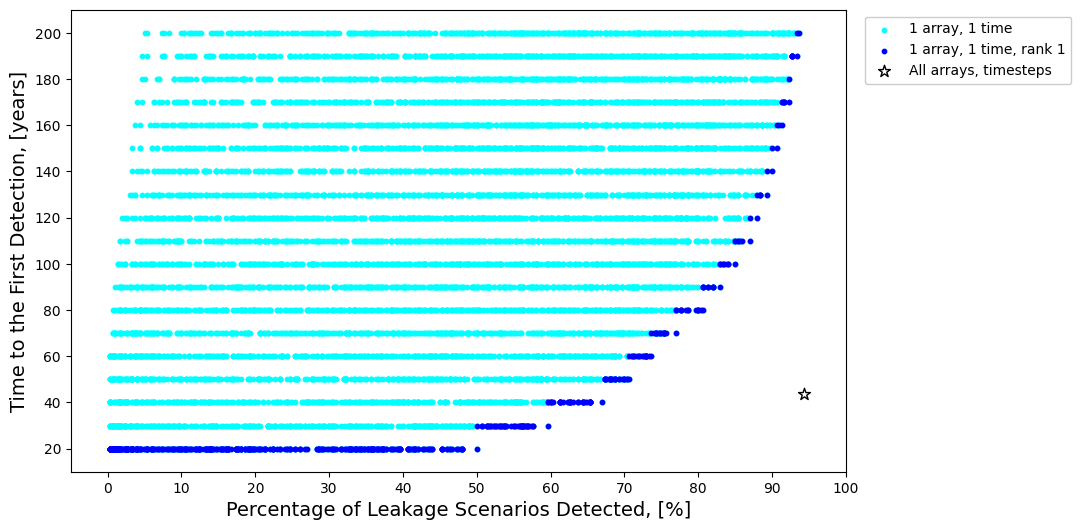

In [41]:
yticks_labels = np.linspace(20, 200, num=10, dtype=int)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(100*x1/num_scenarios, 10*(y1+1), s=10, c='cyan', label='1 array, 1 time')
ax.scatter(100*x1[r1==1]/num_scenarios, 10*(y1[r1==1]+1), s=10, c='blue', label='1 array, 1 time, rank 1')
ax.scatter(100*num_scen_det_best/num_scenarios, 10*np.mean(ttd_best[ttd_best!=np.inf]), s=80, marker='*', ec='black',
            fc='white', zorder=5, label='All arrays, timesteps')
ax.set_xlim((-5, 100))
ax.set_ylim((10, 210))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_yticks(yticks_labels)
ax.set_xticks(np.linspace(0, 100, 11))
ax.set_xlabel('Percentage of Leakage Scenarios Detected, [%]', fontsize=14)
ax.set_ylabel('Time to the First Detection, [years]', fontsize=14)
ax.legend(framealpha=1.0, loc='upper right', bbox_to_anchor=(1.3, 1));

In [42]:
import pickle
# Load data related to the processed plans
plans_sparse = pickle.load(open('data/plans_sparse.pkl', 'rb'))['plans_sparse']
plans_medium = pickle.load(open('data/plans_medium.pkl', 'rb'))['plans_medium']
plans_dense = pickle.load(open('data/plans_dense.pkl', 'rb'))['plans_dense']

#### (b) Optimization is done for several subsets of arrays <a class="anchor" id="bullet8b"></a>

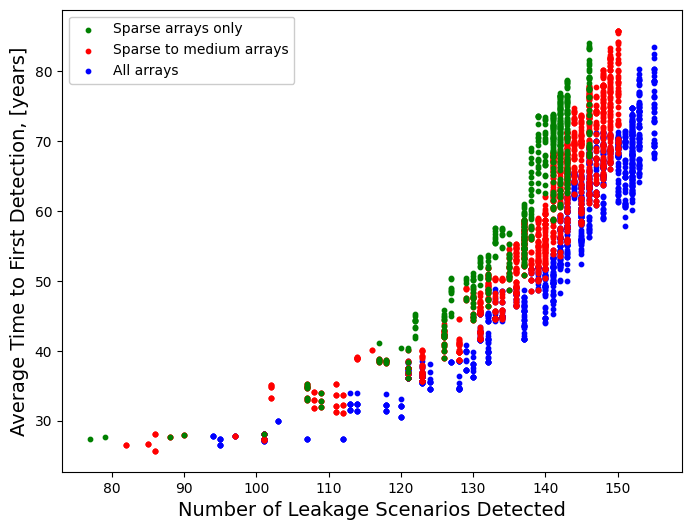

In [43]:
# Plot results of optimization for 3 subsets of arrays for 3 steps (3-arrays in a plan)
plt.figure(figsize=(8, 6))

plt.scatter([plan[1] for plan in plans_sparse], ft([plan[2] for plan in plans_sparse]), 
            s=10, c='green', label='Sparse arrays only', zorder=2)
plt.scatter([plan[1] for plan in plans_medium], ft([plan[2] for plan in plans_medium]), 
            s=10, c='red', label='Sparse to medium arrays', zorder=1)
plt.scatter([plan[1] for plan in plans_dense],  ft([plan[2] for plan in plans_dense]), 
            s=10, c='blue', label='All arrays', zorder=0)

xlim = plt.xlim()
ylim = plt.ylim()
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Number of Leakage Scenarios Detected', fontsize=14)
plt.ylabel('Average Time to First Detection, [years]', fontsize=14)
plt.legend(loc='upper left', framealpha=1.0)
plt.show()

In [44]:
# Load plume data needed for the second plot in JupyterDash window
plume = pickle.load(open('data/plume.pkl', 'rb'))['plume']

cs = {}
i = 0
for key in plume.keys():
    if len(plt.contour(plume[key][-1], levels=[0.2]).collections[0].get_paths()) > 0:
        cs[key] = plt.contour(plume[key][-1], levels=[0.2]).collections[0].get_paths()[0].vertices
plt.close()

In [45]:
# Import needed Python packages for app
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [46]:
nrms = np.load('data/arrays_nrms_data_3rd_max_value_300_scenarios.npz')['data']
threshold = 50
nrmsBool = np.array(nrms > threshold, dtype='bool')

#### (c) JupyterDash App <a class="anchor" id="bullet8c"></a>

In [47]:
app = JupyterDash(__name__)
server = app.server

app.layout = html.Div([
    dcc.Store(id='memory'),
    dcc.Graph(id='pareto', style={'display': 'inline-block'}),
    dcc.Graph(id='arrays', style={'display': 'block'}),
    dcc.Graph(id='plumes', style={'display': 'block'}),
    dcc.Graph(id='detectionTime', style={'display': 'block'}),]) # Define callback to update graph

@app.callback(
    [Output('pareto', 'figure')],
    [Input('memory', 'data')])
def update_figure(colorscale):
    data  = [go.Scatter(x=[plan[1] for plan in plans_sparse],
                        y=ft([plan[2] for plan in plans_sparse]),
                        name='Sparse arrays only',
                        mode='markers',
                        marker=dict(color='blue', size=5))]
    data += [go.Scatter(x=[plan[1] for plan in plans_medium],
                        y=ft([plan[2] for plan in plans_medium]),
                        name='Sparse to medium arrays',
                        mode='markers',
                        marker=dict(color='red',size=5))]
    data += [go.Scatter(x=[plan[1] for plan in plans_dense],
                        y=ft([plan[2] for plan in plans_dense]),
                        name='All arrays',
                        mode='markers',
                        marker=dict(color='green', size=5))]
    fig = go.Figure(data=data[::-1])
    fig.update_layout(margin=dict(l=20, r=20, t=40, b=20), width=875, height=350 )
    fig.update_layout(xaxis_title='# Leakage Scenarios Detected')
    fig.update_layout(yaxis_title='Avg Time to First Detection, [years]')
    return [fig]

@app.callback(
    [Output('arrays', 'figure')],
    [Input("pareto", "clickData")])
def update_figure(click):
    source_x = np.linspace(0, 1000, 101)
    source_y = np.zeros(101)
    receiver_x = np.linspace(0, 1000, 9)
    receiver_y = np.zeros(101) + 10
    ii = np.random.choice(range(101), 50)
    data = []
    print('click', click)
    if click['points'][0]['curveNumber'] == 0: 
        plans = plans_dense
    if click['points'][0]['curveNumber'] == 1: 
        plans = plans_medium
    if click['points'][0]['curveNumber'] == 2: 
        plans = plans_sparse
        
    kk = 0
    for iDeployment in list(plans)[click['points'][0]['pointNumber']][0]:
        kk += 1
        if kk == 1:
            data += [go.Scatter(x=4000 + 4*np.array(source_x),
                                y=np.array(source_y) + 30*kk,
                                mode='markers',
                                marker=dict(color='gray', size=5),
                                name='Potential Receiver Positions')]
            data += [go.Scatter(x=4000 + 4*np.array(receiver_x),
                                y=np.array(receiver_y) + 30*kk,
                                mode='markers',
                                marker=dict(color='gray', size=10),
                                name='Potential Source Positions')]
        else:
            data += [go.Scatter(x=4000 + 4*np.array(source_x),
                                y=np.array(source_y) + 30*kk,
                                mode='markers',
                                showlegend=False,
                                marker=dict(color='gray', size=5))]
            data += [go.Scatter(x=4000 + 4*np.array(receiver_x),
                                y=np.array(receiver_y) + 30*kk,
                                mode='markers',
                                showlegend=False,
                                marker=dict(color='gray', size=10))]

    kk=0
    for iDeployment in list(plans)[click['points'][0]['pointNumber']][0]:
        kk+=1
        # Uncomment the following two lines for extra information about selected plans
        # print('iDeployment', iDeployment)
        # print('array', produced_arrays[iDeployment[0]])
        if click['points'][0]['curveNumber'] == 0:
            ii = produced_arrays[iDense[iDeployment[0]]]['receivers']
            jj = produced_arrays[iDense[iDeployment[0]]]['source']
        if click['points'][0]['curveNumber'] == 1:
            ii = produced_arrays[iMedium[iDeployment[0]]]['receivers']
            jj = produced_arrays[iMedium[iDeployment[0]]]['source']
        if click['points'][0]['curveNumber'] == 2:
            ii = produced_arrays[iSparse[iDeployment[0]]]['receivers']
            jj = produced_arrays[iSparse[iDeployment[0]]]['source']

        if kk==1:
            data += [go.Scatter(x=4000 + 4*np.array(source_x[ii]),
                                y=np.array(source_y[ii])+30*kk,
                                mode='markers',
                                marker=dict(color='blue',size=5),
                                name='Selected Receiver Positions')]
            data += [go.Scatter(x=4000 + 4*np.array([receiver_x[jj]]),
                                y=np.array([receiver_y[jj]])+30*kk,
                                mode='markers',
                                marker=dict(color='red',size=10),
                                name='Selected Source Positions')]
            data += [go.Scatter(x=[3600],
                                y=[30*kk + 5],
                                text=['Year %i'%ft(iDeployment[1])],
                                showlegend=False,
                                mode='text')]
        else:
            data += [go.Scatter(x=4000 + 4*np.array(source_x[ii]),
                                y=np.array(source_y[ii]) + 30*kk,
                                mode='markers',
                                showlegend=False,
                                marker=dict(color='blue', size=5))]
            data += [go.Scatter(x=4000 + 4*np.array([receiver_x[jj]]),
                                y=np.array([receiver_y[jj]]) + 30*kk,
                                mode='markers',
                                showlegend=False,
                                marker=dict(color='red', size=10))]
            data += [go.Scatter(x=[3600],
                                y=[30*kk + 5],
                                text=['Year %i'%ft(iDeployment[1])],
                                showlegend=False,
                                mode='text')]

    fig = go.Figure(data=data)
    fig.update_layout(margin=dict(l=20, r=20, t=40, b=20), width=900, height=225)
    fig.update_layout(xaxis_title='Distance Along Survey, [m]')
    #fig.update_layout(yaxis_title='Depth [m]')
    fig.update_yaxes(showticklabels=False)

    return [fig]


@app.callback(
    [Output('plumes', 'figure')],
    [Input("pareto", "clickData")])
def update_figure(click):
    if click['points'][0]['curveNumber'] == 0: 
        plans = plans_dense
    if click['points'][0]['curveNumber'] == 1: 
        plans = plans_medium
    if click['points'][0]['curveNumber'] == 2: 
        plans = plans_sparse
        
    detected = []
    for iDeployment in list(plans)[click['points'][0]['pointNumber']][0]:
        detected += list(np.where(nrmsBool[iDeployment[0], :, iDeployment[1]])[0])
        
    detectable = list(np.where(np.any(nrmsBool, axis=(0, 2)))[0])
    data = []
    for key in cs.keys():
        if key in detectable:
            if key in detected:
                data += [go.Scatter(x=4000 + 10*cs[key][:, 1],
                                    y=10*cs[key][:, 0],
                                    showlegend=False,
                                    fill='tonexty',
                                    line=dict(color='gray'),
                                    fillcolor='rgba(150,150,150,0.25)')]
        if key in detectable:
            if key not in detected:
                data += [go.Scatter(x=4000 + 10*cs[key][:, 1],
                                    y=10*cs[key][:, 0],
                                    showlegend=False,
                                    fill='tonexty',
                                    line=dict(color='red'),
                                    fillcolor='rgba(256,0,0,0.25)')]
    fig = go.Figure(data=data[::-1])
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(xaxis_title='Distance Along Survey, [m]')
    fig.update_layout(yaxis_title='Depth, [m]')
    return [fig]


@app.callback(
    [Output('detectionTime', 'figure')],
    [Input("pareto", "clickData")])
def update_figure(click):
    if click['points'][0]['curveNumber'] == 0: 
        plans = plans_dense
    if click['points'][0]['curveNumber'] == 1: 
        plans = plans_medium
    if click['points'][0]['curveNumber'] == 2: 
        plans = plans_sparse
        
    detected = []
    for iDeployment in list(plans)[click['points'][0]['pointNumber']][0]:
        detected += list(np.where(nrmsBool[iDeployment[0], :, iDeployment[1]])[0])
    detectable = list(np.where(np.any(nrmsBool, axis=(0, 2)))[0])

    ts = list(range(nrmsBool.shape[2]))
    det = [np.sum(np.any(nrmsBool[:, :, i], axis=0)) for i in range(nrmsBool.shape[2])]
    ts_step, det_step = scatter2step(ts, det)
    data = [go.Scatter(x=ft(ts_step), y=det_step, name='All Surveys')]

    plan = list(plans)[click['points'][0]['pointNumber']]
    ts  = [0] + [deployment[1] for deployment in plan[0]] + [19]
    detList = []
    for i in range(len(ts)-2):
        detList += [np.where(nrmsBool[plan[0][i][0], :, plan[0][i][1]])[0]]
    det = []
    for i in range(3):
        detUnique = []
        for j in range(i + 1):
            detUnique += detList[j].tolist()
        det += [len(np.unique(detUnique))]
    det  = [0] + det
    det += [det[-1]]
    ts_step, det_step = scatter2step(ts, det)
    data += [go.Scatter(x=ft(ts_step), y=det_step, mode='lines',
                        name='Selected Plan (#%i)'%click['points'][0]['pointNumber'])]

    fig = go.Figure(data=data)
    fig.update_layout(xaxis_title='Time, [years]')
    fig.update_layout(yaxis_title='Number of Leakage Scenarios Detected')
    return [fig]


app.run_server(mode="inline")

C:\programs\Python\Python3810\lib\site-packages\dash\dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.
  warnings.warn(
